# CIFAR10 Classification



## Import Libraries

Import needed libraries

In [42]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Device

Set device to work with (GPU or CPU)

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [44]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [45]:
transform_train = transforms.ToTensor()
transform_test = transforms.ToTensor()

In [46]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):

        for channel in range(tensor.size(0)):
            tensor[channel] = tensor[channel] * self.std[channel] + self.mean[channel]

        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [47]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [48]:
train_size=int(len(initial_trainset)*0.7)
valid_size=int(len(initial_trainset)- train_size)

In [49]:
trainset, valset = torch.utils.data.random_split(initial_trainset,[train_size,valid_size] )

In [50]:
torch.manual_seed(101)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
valloader = torch.utils.data.DataLoader(valset,batch_size=32,shuffle=False)

In [51]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=len(testset),shuffle=False)

Files already downloaded and verified


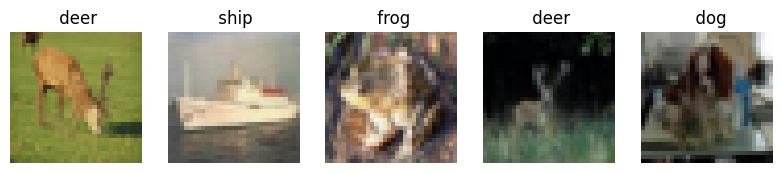

In [75]:
# np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 4))

for i in range(5):
    fig.add_subplot(2, 10, i + 1)
    image, label = trainset[5*i+1]
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(class_names[label])
    plt.axis('off')

plt.show()

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [52]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [53]:
model3=ResNet(BasicBlock, [2, 2, 2, 2])
model3=model3.to(device)

## Train

### Criterion & Optimizater

`criterion` and `optimizer` (Or `scheduler`)

In [54]:
criterion =nn.CrossEntropyLoss().to(device)
optimizer =torch.optim.Adam(model3.parameters(),lr=0.001)
scheduler =torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3)
scheduler=None

### Train loop

- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [55]:
from tqdm.notebook import tqdm
from time import time

In [56]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    trn_losses=0
    trn_corr=0
    t_loss=[]
    t_acc=[]
    total=0
    for i, (x_train,y_train) in enumerate(dataloader):
        x_train,y_train=x_train.to(device), y_train.to(device)
        optimizer.zero_grad()

        y_preds=net(x_train)

        loss=criterion(y_preds,y_train)
        loss.backward()
        optimizer.step()


        predicted=torch.max(y_preds.data,1)[1]
        trn_corr+=(predicted==y_train).sum().item()

        total += y_train.size(0)


        if scheduler is not None:
          scheduler.step()

        trn_losses+=loss.item()


    epoch_accuracy=100*trn_corr/total
    epoch_loss=trn_losses/len(trainloader)
    t_loss.append(epoch_loss)
    t_acc.append(epoch_accuracy)
    print(f"TRAIN_LOSS:{epoch_loss:.4f}     TRAIN_ACC:{epoch_accuracy:.2f}")
    return epoch_loss , epoch_accuracy
def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
      val_losses=0
      val_corr=0
      v_loss=[]
      v_acc=[]
      total_val=0
      with torch.no_grad():

          for i, (x_val,y_val) in enumerate(dataloader):
              i+=1
              x_val,y_val=x_val.to(device), y_val.to(device)

              y_pred_val=net(x_val)

              val_loss=criterion(y_pred_val,y_val)

              predicted=torch.max(y_pred_val.data,1)[1]

              val_corr+=(predicted==y_val).sum().item()

              total_val += y_val.size(0)

              val_losses+=val_loss.item()


          epoch_accuracy_val = 100 * val_corr / total_val
          epoch_loss_val=val_losses/len(valloader)
          v_acc.append(epoch_accuracy_val)
          v_loss.append(val_losses)
          print(f"VALIDATION_LOSS:{epoch_loss_val:.4f}     VALIDATION_ACC:{epoch_accuracy_val:.2f}")
      return epoch_loss_val,epoch_accuracy_val








In [57]:
epochs =7
t_loss=[]
t_acc=[]
v_loss=[]
v_acc=[]
for e in range(epochs):
    print(f"EPOCH:{e+1}")
    train_loss, train_accuracy=train_epoch(model3,criterion,optimizer,scheduler,trainloader)
    t_loss.append(train_loss)
    t_acc.append(train_accuracy)
    valid_loss, valid_accuracy=eval_epoch(model3,criterion,valloader)
    v_loss.append(valid_loss)
    v_acc.append(valid_accuracy)

EPOCH:1
TRAIN_LOSS:1.4687     TRAIN_ACC:46.39
VALIDATION_LOSS:1.1310     VALIDATION_ACC:59.30
EPOCH:2
TRAIN_LOSS:0.9610     TRAIN_ACC:65.99
VALIDATION_LOSS:0.8705     VALIDATION_ACC:70.21
EPOCH:3
TRAIN_LOSS:0.7267     TRAIN_ACC:74.54
VALIDATION_LOSS:0.7059     VALIDATION_ACC:75.47
EPOCH:4
TRAIN_LOSS:0.5731     TRAIN_ACC:79.71
VALIDATION_LOSS:0.6340     VALIDATION_ACC:78.23
EPOCH:5
TRAIN_LOSS:0.4533     TRAIN_ACC:84.09
VALIDATION_LOSS:0.5857     VALIDATION_ACC:80.19
EPOCH:6
TRAIN_LOSS:0.3439     TRAIN_ACC:87.93
VALIDATION_LOSS:0.5949     VALIDATION_ACC:80.69
EPOCH:7
TRAIN_LOSS:0.2449     TRAIN_ACC:91.34
VALIDATION_LOSS:0.6296     VALIDATION_ACC:80.93


### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

Text(0.5, 1.0, 'ACCURACY')

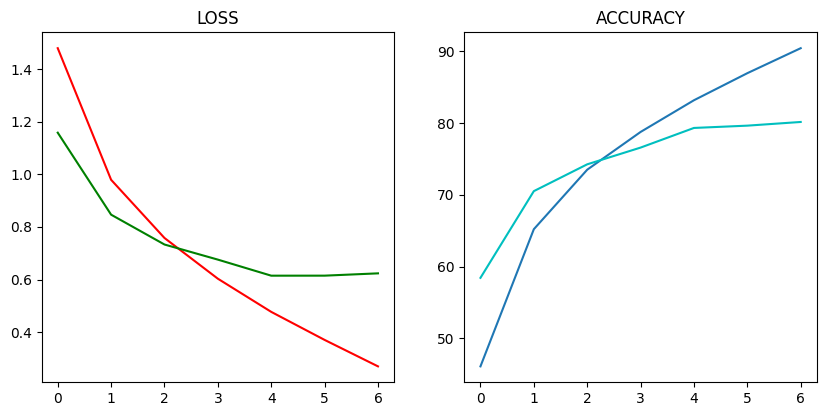

In [ ]:

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(t_loss,c="r")
plt.plot(v_loss,c="g")
plt.title("LOSS")
plt.subplot(222)
plt.plot(t_acc)
plt.plot(v_acc,c="c")
plt.title("ACCURACY")

## Evaluation

 Our goal is to reach an accuracy above `80%`

In [ ]:

with torch.no_grad():
  test_corr=0
  total_test=0
  test_losses=0
  for input,label in testloader:
    input, label=input.to(device),label.to(device)
    output=model3(input)
    loss=criterion(output,label)
    predicted=torch.max(output.data,1)[1]

    test_corr+=(predicted==label).sum().item()
    total_test += label.size(0)

    test_losses+=loss.item()
  accuracy=100*test_corr/total_test
  AVG_TEST_LOSS=test_losses/len(testloader)
  print(f"LOSS: {AVG_TEST_LOSS}, accuracy:{accuracy}")

LOSS: 0.6203917860984802, accuracy:81.18


In [58]:
torch.save(model3.state_dict(), 'CIFAR10-classification-Model.pt')

In [59]:
model = ResNet(BasicBlock, [2, 2, 2, 2])
model.load_state_dict(torch.load("/content/CIFAR10-classification-Model.pt"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## Visualizing incorrectly predicted samples from testset

In [ ]:

with torch.no_grad():

    x,y=input,label
    x,y=x.to(device) , y.to(device)
    # print(y)
    y_predect=model3(x)
    predicted = torch.max(y_predect.data, 1)[1]

    print((y==predicted)[:500])

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True, False, False, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [ ]:
def plot_pic(x,y):
  plt.imshow(np.transpose(x.detach().cpu().numpy(), (1, 2, 0)))
  plt.title(f"{y}")
  plt.axis("off")

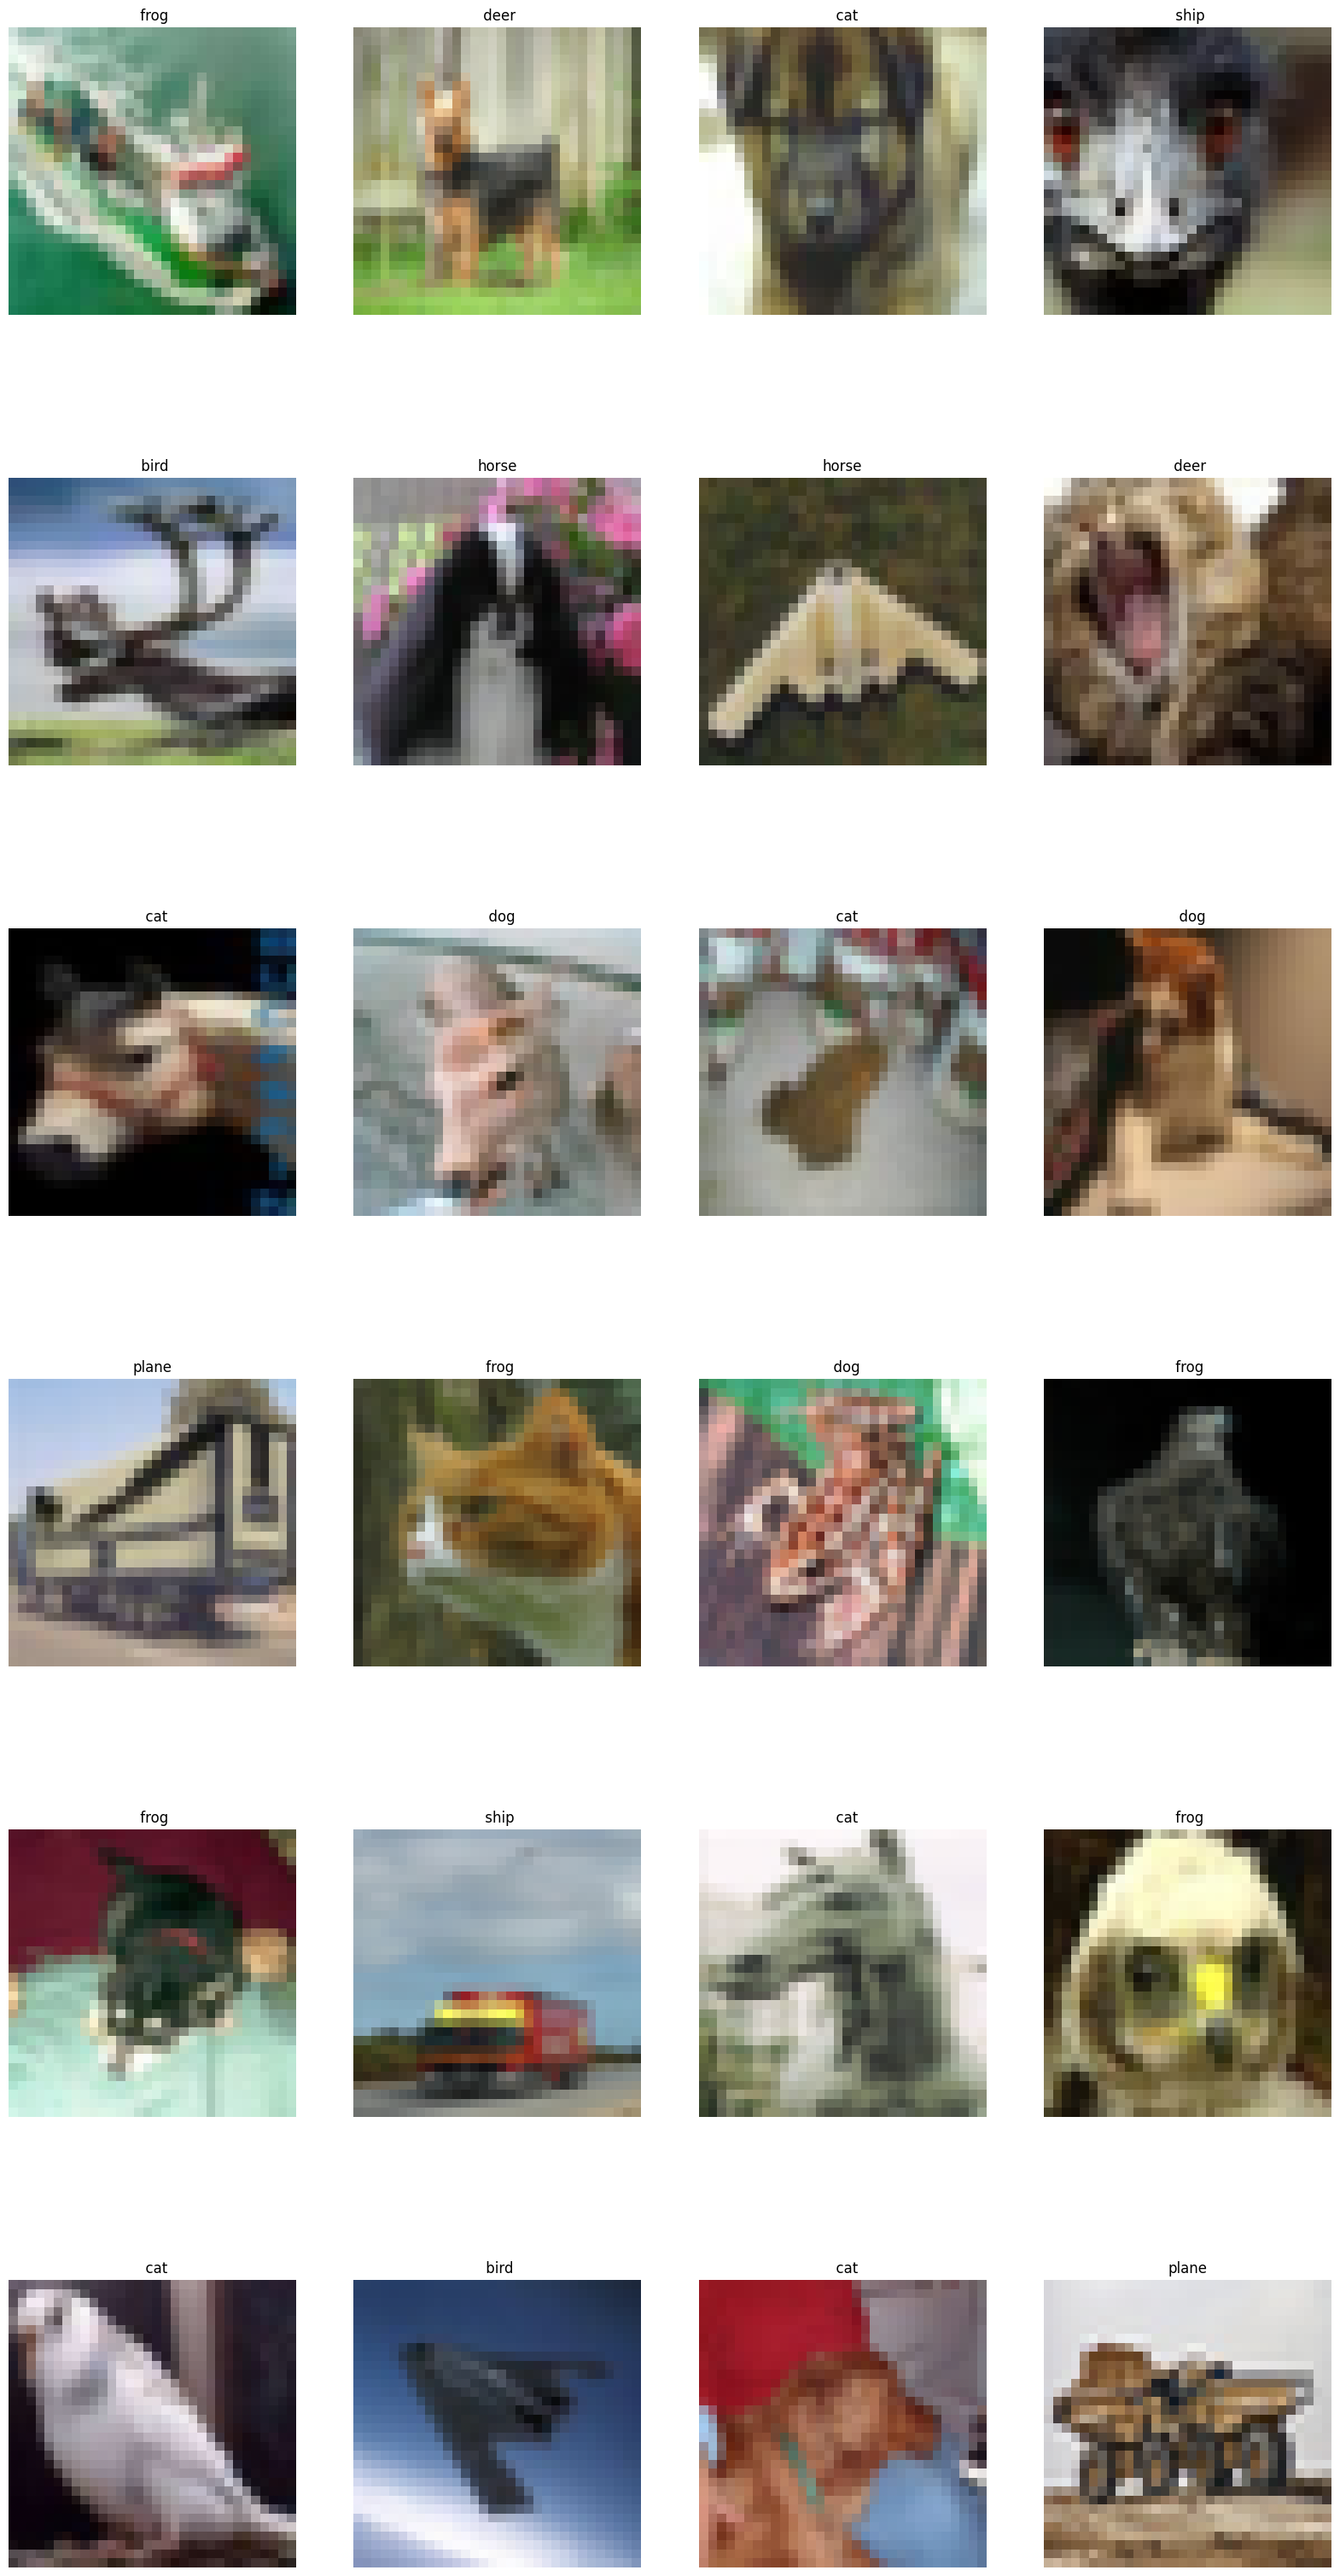

In [ ]:
no_false=[]
for i,j in enumerate((y==predicted)[:500]):
    if j==False:
        no_false.append(i)
fig = plt.figure(figsize=(20, 40))
for s in range(24):

  fig.add_subplot(6, 4, s + 1)
  plot_pic(input[no_false[s]],class_names[predicted[no_false[s]]])



## Exploring the feature space

In [60]:
from tqdm.notebook import tqdm
# model=model.to(device)
alltrainloader1 = torch.utils.data.DataLoader(initial_trainset,batch_size=1,shuffle=False)

clipped=nn.Sequential(*list(model.children())[0:6]).to(device)
features=torch.zeros(50000,512,4,4)
with torch.no_grad():
  I=0
  for  input_, _ in tqdm(alltrainloader1):
      input_=input_.to(device)
      features[I]=clipped(input_)
      I+=1




  0%|          | 0/50000 [00:00<?, ?it/s]

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section



In [62]:
testloader1 = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=False)
X_output=torch.zeros(len(testset),512,4,4)
I=0
with torch.no_grad():
  for x_test , _ in tqdm(testloader1):
    x_test=x_test.to(device)
    X_output[I]=clipped(x_test)
    I+=1


  0%|          | 0/10000 [00:00<?, ?it/s]

In [63]:
X_output.shape

torch.Size([10000, 512, 4, 4])

In [64]:

k = 5
nearest_neighbors_indices = []
random=[10,25,67,75,86]
S=features
X=torch.zeros(5,512,4,4)
for i in range(5):
    X[i]=X_output[random[i]]
    distances = torch.linalg.norm(X[i].flatten() - S.view(50000, -1), dim=1)  # Compute L2 distance
    _, topk_indices = torch.topk(distances, k=k, largest=False)  # Find top k nearest neighbors
    nearest_neighbors_indices.append(topk_indices)

for i in range(5):
    print(f"Nearest neighbors for test sample {i}: {nearest_neighbors_indices[i]}")

Nearest neighbors for test sample 0: tensor([19011,  2426, 34276, 45458, 12457])
Nearest neighbors for test sample 1: tensor([ 2868,  2875, 39931,  9498, 18948])
Nearest neighbors for test sample 2: tensor([26390, 45367, 43757,  6757, 22693])
Nearest neighbors for test sample 3: tensor([29354, 39931, 23064, 11548, 43692])
Nearest neighbors for test sample 4: tensor([15139, 35348,  4034, 46801, 24994])


### TSNE

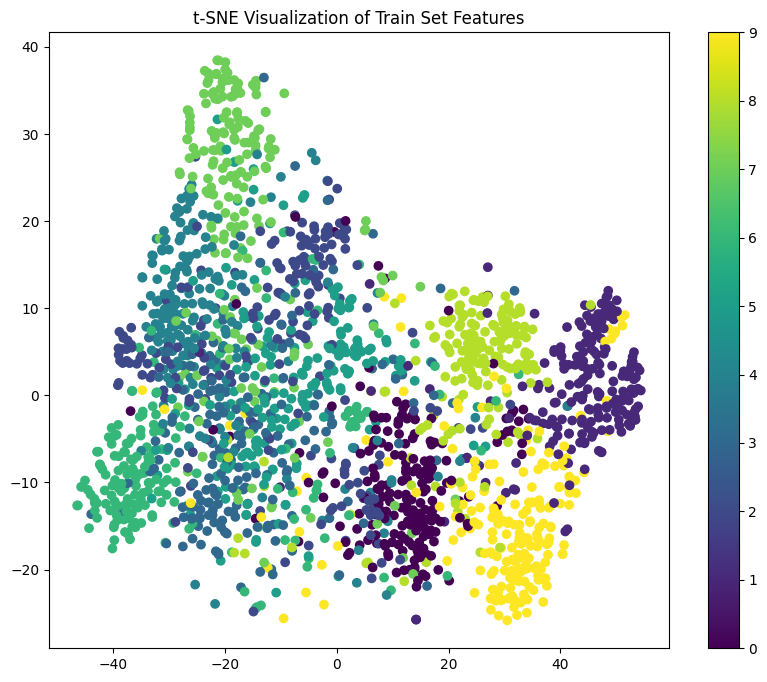

In [77]:

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

torch.manual_seed(101)
trainloader3=torch.utils.data.DataLoader(testset,batch_size=2000,shuffle=True)
features2000=torch.zeros(2000,512,4,4)
with torch.no_grad():
  for input_1,label in trainloader3:
      input_1=input_1.to(device)
      features2000=clipped(input_1)
      break





M = 2000
S1=features2000.reshape(M,-1).detach().cpu().numpy()
# random_indices = np.random.choice(len(S), M, replace=False)
# random_samples = S[random_indices]

# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2, random_state=101)
tsne_features = tsne.fit_transform(S1)

# Visualize the 2D t-SNE embeddings with color based on class labels
plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1],c=label[:M], cmap='viridis')

plt.colorbar()
plt.title('t-SNE Visualization of Train Set Features')
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
class BlackAndWhiteCIFAR10(Dataset):


    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.Ciffar10_dataset=CIFAR10(root, train=train,download=download, transform=transform)
        self.transform=transform
        self.tograyscale=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Grayscale(num_output_channels=1)])


    def __len__(self):
        return len(self.Ciffar10_dataset)

    def __getitem__(self, index):


        RGB_Img ,target= self.Ciffar10_dataset[index]


        #conver to grayscale
        togray=torchvision.transforms.Grayscale(num_output_channels=1)
        BW_Img=togray(RGB_Img)

        # if self.transform:

        #     RGB_Img=self.transform(RGB_Img)
        #     BW_Img=self.transform(BW_Img)

        return  BW_Img,RGB_Img




## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
transform_train =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

transform_test =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [ ]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,download=True, transform=transform_train)


100%|██████████| 170498071/170498071 [00:02<00:00, 81998417.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_size=int(len(initial_trainset)*0.7)
valid_size=int(len(initial_trainset)- train_size)
trainset, valset =torch.utils.data.random_split(initial_trainset,[train_size,valid_size] )

In [ ]:
trainloader =torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
valloader =torch.utils.data.DataLoader(valset,batch_size=32,shuffle=True)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

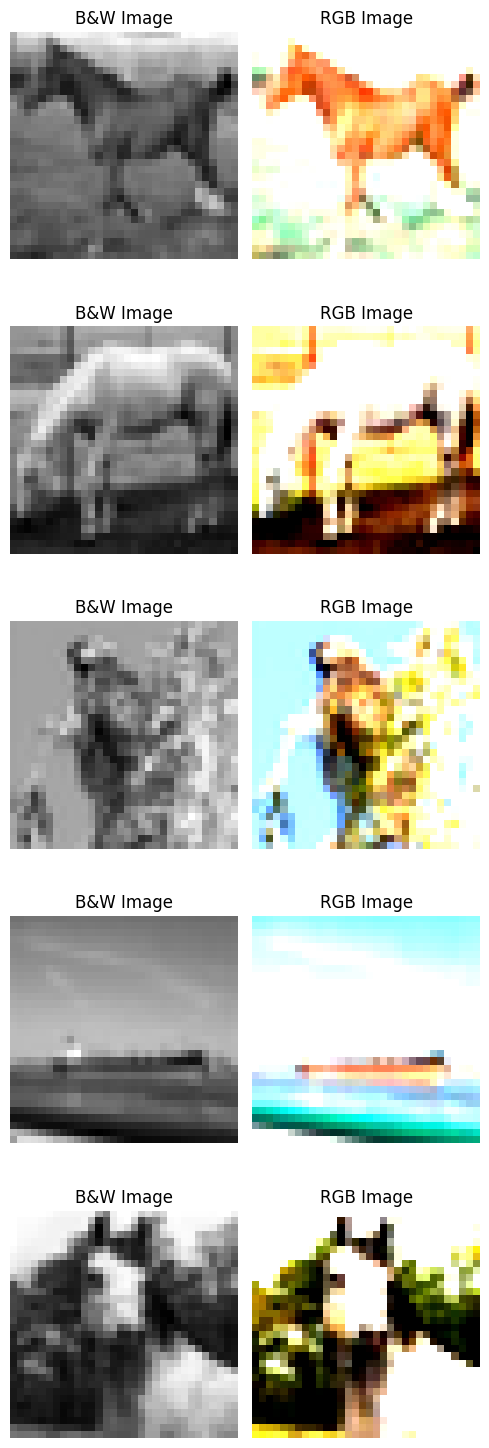

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


sample_batch = next(iter(trainloader))


bw_images,rgb_images = sample_batch


num_samples = 5

# Plot the images side by side
fig, axes = plt.subplots(num_samples, 2, figsize=(5, 3 * num_samples))
for i in range(num_samples):

    bw_np = bw_images[i].numpy().transpose(1, 2, 0)
    rgb_np = rgb_images[i].numpy().transpose(1, 2, 0)  # Transpose to (H, W, C)

    # Plot B&W image
    axes[i, 0].imshow(bw_np,cmap="gray")
    axes[i, 0].set_title("B&W Image")
    axes[i, 0].axis('off')

    # Plot RGB image
    axes[i, 1].imshow(rgb_np)
    axes[i, 1].set_title("RGB Image")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Model



In [ ]:

import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self,in_features,out_features):
        super(ConvBlock, self).__init__()
        self.conv1=nn.Conv2d(in_features,out_features,3,1,1)
        self.conv2=nn.Conv2d(out_features,out_features,3,1,1)


    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        return x

class TransConvBlock(nn.Module):
    def __init__(self,in_features,out_features):
        super(TransConvBlock, self).__init__()
        self.transconv=nn.ConvTranspose2d(in_features,out_features,3,2,1,1)
        self.conv3=nn.Conv2d(in_features,out_features,3,1,1)
        self.conv4=nn.Conv2d(out_features,out_features,3,1,1)

    def forward(self, x, skip_input):
        x=self.transconv(x)
        x=torch.cat([x,skip_input],dim=1)
        x=F.relu(self.conv3(x))
        x=F.relu(self.conv4(x))

        return x

class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1=ConvBlock(1,64)
        self.conv2=ConvBlock(64,128)
        self.conv3=ConvBlock(128,256)
        self.conv4=ConvBlock(256,512)
        self.conv5=ConvBlock(512,1024)
        self.maxpool=nn.MaxPool2d(2,2)
        self.transblock1=TransConvBlock(1024,512)
        self.transblock2=TransConvBlock(512,256)
        self.transblock3=TransConvBlock(256,128)
        self.transblock4=TransConvBlock(128,64)

        self.conv1_1=nn.Conv2d(64,3,1,1,0)

    def forward(self, x):
        out1=self.conv1(x)
        x=self.maxpool(out1)
        out2=self.conv2(x)
        x=self.maxpool(out2)
        out3=self.conv3(x)
        x=self.maxpool(out3)
        out4=self.conv4(x)
        x=self.maxpool(out4)
        out5=self.conv5(x)


        out6=self.transblock1(out5,out4)
        out7=self.transblock2(out6,out3)
        out8=self.transblock3(out7,out2)
        out9=self.transblock4(out8,out1)

        out=self.conv1_1(out9)


        return out

In [ ]:
model=ColorizationNet()
model

ColorizationNet(
  (conv1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): ConvBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv5): ConvBlock(
    (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
net =ColorizationNet().to(device)

In [ ]:
criterion =nn.MSELoss().to(device)
optimizer =torch.optim.Adam(net.parameters(),lr=1e-3)

In [ ]:
from tqdm.notebook import tqdm
from time import time

In [ ]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    trn_loss=0
    batch_size=0

    for batch in tqdm(dataloader):
        batch_size+=1
        bw,rgb=batch
        bw=bw.to(device)
        rgb=rgb.to(device)

        optimizer.zero_grad()

        rgb_output=net(bw)
        loss=criterion(rgb_output,rgb)


        loss.backward()
        optimizer.step()
        trn_loss+=loss.item()
    print(f"train Loss: {trn_loss/batch_size:.4f}")
    return trn_loss/batch_size


def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    with torch.no_grad():
        vld_loss=0
        batch_size=0

        for batch in tqdm(dataloader):
            batch_size+=1
            bw_val , rgb_val=batch
            bw_val , rgb_val= bw_val.to(device) , rgb_val.to(device)

            val_output=net(bw_val)
            loss_val=criterion(val_output,rgb_val)
            vld_loss+=loss_val.item()
        print(f"Validation Loss: {vld_loss/batch_size:.4f}")
        return vld_loss/batch_size

In [ ]:
epochs =20
trainloss=[]
validloss=[]

for e in range(epochs):
    print(f"Epoch: {e+1}")
    trnloss=train_epoch(net,criterion,optimizer,trainloader)
    vldloss=eval_epoch(net,criterion,valloader)
    trainloss.append(trnloss)
    validloss.append(vldloss)

Epoch: 1


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 2.3470


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0662
Epoch: 2


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0630


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0611
Epoch: 3


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0599


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0582
Epoch: 4


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0581


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0563
Epoch: 5


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0573


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0553
Epoch: 6


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0565


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0550
Epoch: 7


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0558


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0569
Epoch: 8


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0563


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0673
Epoch: 9


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0620


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0605
Epoch: 10


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0578


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0560
Epoch: 11


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0562


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0562
Epoch: 12


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0552


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0545
Epoch: 13


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0545


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0535
Epoch: 14


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0537


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0610
Epoch: 15


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0560


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0560
Epoch: 16


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0537


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0540
Epoch: 17


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0524


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0542
Epoch: 18


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0515


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0548
Epoch: 19


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0520


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0556
Epoch: 20


  0%|          | 0/1094 [00:00<?, ?it/s]

train Loss: 0.0511


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.0543


### Visualize Loss plot



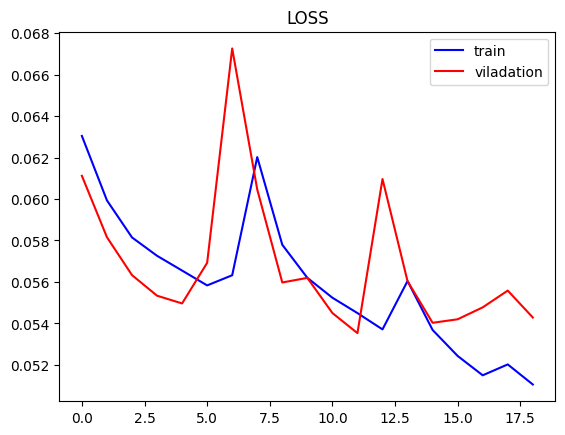

In [ ]:

import matplotlib.pyplot as plt
plt.plot(trainloss[1:],c="b",label="train")
plt.plot(validloss[1:],c="r",label="viladation")
plt.title("LOSS")
plt.legend()

## Evaluation



In [ ]:
testset =BlackAndWhiteCIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader =DataLoader(testset,batch_size=36,shuffle=False)

Files already downloaded and verified


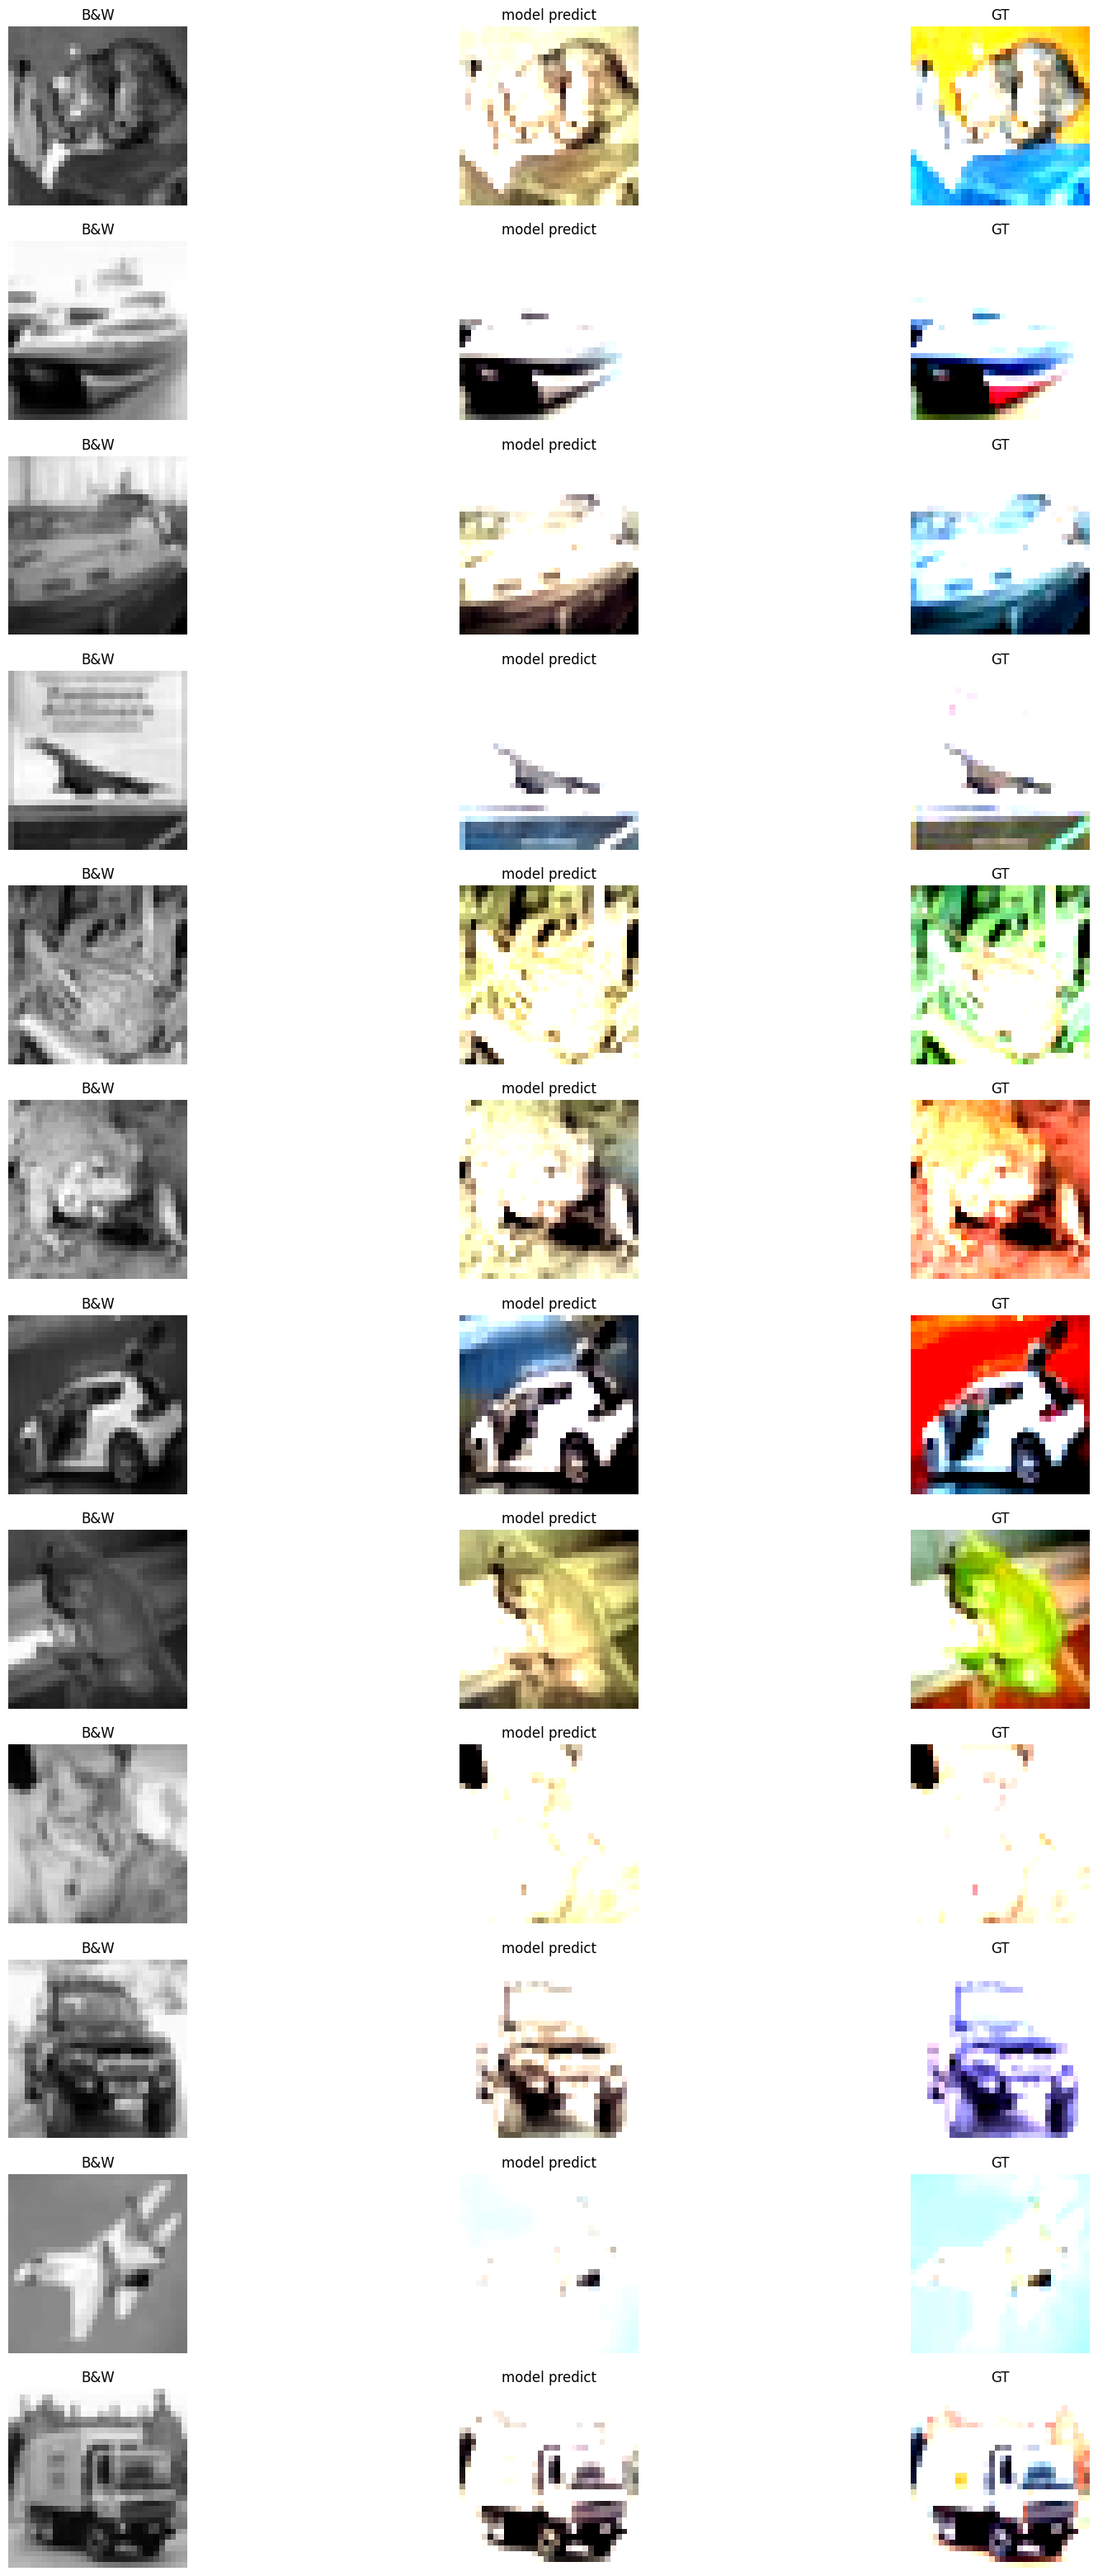

In [ ]:

for BW_PIC , RGB_PIC in testloader:
    BW_PIC,RGB_PIC=BW_PIC.to(device),RGB_PIC.to(device)
    break
with torch.no_grad():

  OUTPUT_PIC=net(BW_PIC)

fig = plt.figure(figsize=(20, 40))
n=0
for i in range(0,36,3):
    fig.add_subplot(12, 3, i + 1)
    plt.imshow(BW_PIC[n].permute(1, 2, 0).detach().cpu().numpy(),cmap="gray")
    plt.title("B&W")
    plt.axis('off')
    fig.add_subplot(12, 3, i + 2)
    plt.imshow(OUTPUT_PIC[n].permute(1, 2, 0).detach().cpu().numpy())
    plt.title("model predict")
    plt.axis('off')
    fig.add_subplot(12, 3, i + 3)
    plt.imshow(RGB_PIC[n].permute(1, 2, 0).detach().cpu().numpy())
    plt.title("GT")
    plt.axis('off')
    n+=1